<a href="https://colab.research.google.com/github/Vladislav-GitHub/DL-and-NLP-ITMO-course/blob/hw_3/NLP_3_task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Импорт данных

In [ ]:
!pip install contractions
!pip install -U spacy
!python3 -m spacy download en_core_web_sm

In [92]:
import os
import contractions
import gensim, logging
import json
import nltk
import random
import spacy
import tempfile
import warnings
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from gensim.models import Word2Vec
from gensim.models.fasttext import FastText
from gensim.test.utils import datapath
from nltk.corpus import stopwords
from sklearn.linear_model import LogisticRegression
from sklearn.manifold import TSNE
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score
from zipfile import ZipFile

In [93]:
USERNAME = input("Укажите ваш ник в Kaggle:\n")
KEY = input("\nУкажите ваш токен в Kaggle:\n")
api_token = {"username": USERNAME, "key": KEY}

In [ ]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d uciml/sms-spam-collection-dataset

In [95]:
ZIP_PATH = input("\nУкажите полный путь к .zip файлу:\n")

with ZipFile(ZIP_PATH, 'r') as zip_ref:
    zip_ref.extractall()

In [96]:
with open('/root/.kaggle/kaggle.json', 'w+') as file:
    json.dump(api_token, file)

In [ ]:
seed = 42
random.seed(seed)
np.random.seed(seed)
warnings.simplefilter("ignore", UserWarning)
warnings.simplefilter("ignore", RuntimeWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
pd.set_option('max_colwidth', 400)
nltk.download('stopwords')
nltk.download('punkt')
stop_words = set(stopwords.words("english"))
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

# Набор данных
[
SMS Spam Collection Dataset](https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset)

SMS Spam Collection - это множество СМС сообщений, которые были получены согласно исследованию "SMS Spam". Оно содержит одно множество из 5574 английских СМС сообщений, отмеченные как **ham** (не спам) или **spam** (спам).

In [ ]:
FILE_PATH = input("Укажите полный путь к .csv файлу:\n")
data = pd.read_csv(FILE_PATH, encoding='iso-8859-1')[['v1', 'v2']].rename(columns={'v1': 'label', 'v2': 'text'})
data['label'] = data['label'].map({'ham': 0, 'spam': 1})

# Предобработка данных

In [120]:
def replace_contractions(text):
    """
    Заменить сокращения в тексте
    """
    return contractions.fix(text)

nlp = spacy.load("en_core_web_sm")

data['cleaned_text'] = data['text'].apply(
    lambda x: ' '.join(
        token.lemma_.lower() for token in nlp(x) if
        not token.is_stop
        and not token.is_punct
        and not token.is_digit
        and token.is_ascii
        and not token.like_email
        and not token.like_num
        and not token.like_url
        and not token.is_space
    ),
    replace_contractions
)

X_train, X_test, y_train, y_test = train_test_split(data[['cleaned_text']], data[['label']], test_size=0.2, shuffle=True, random_state=42)

In [100]:
class MyCorpus():
    """
    An iterator that yields sentences (lists of str).
    """
    def __init__(self, X):
      self.X = X

    def __iter__(self):
        for lab, row in self.X.iterrows():
            yield np.asarray(row)[0].split()

# Skip-Gram

In [ ]:
%%time

sentences = MyCorpus(X_train)

model_sg = Word2Vec(
    sentences=sentences,
    vector_size=256,
    window=7,
    compute_loss=True,
    min_count=2,
    sg=1,
    hs=0,
    negative=5,
    epochs=25,
    seed=seed
)

In [ ]:
print(f"{model_sg.wv.most_similar('buy', topn=10)}")
training_loss = model_sg.get_latest_training_loss()
print(f"Skip-Gram потери: {training_loss}")
model_sg.save('my.model_sg')

# CBOW

In [ ]:
%%time

model_cbow = Word2Vec(
    sentences=sentences,
    vector_size=256,
    window=7,
    compute_loss=True,
    min_count=2,
    sg=0,
    hs=1,
    negative=0,
    epochs=25,
    seed=seed
)

In [ ]:
print(f"{model_cbow.wv.most_similar('buy', topn=10)}")
training_loss = model_cbow.get_latest_training_loss()
print(f"CBOW потери: {training_loss}")
model_cbow.save('my.model_cbow')

# FastText

In [ ]:
%%time

text = ' '.join([' '.join(x) for x in iter(sentences)])

with open('data.txt', 'w') as f:
  f.write(text)
corpus_file = datapath('/content/data.txt')
model_fasttext = FastText(vector_size=100)
model_fasttext.build_vocab(corpus_file=corpus_file)

# Тренировка модели
model_fasttext.train(
    corpus_file=corpus_file,
    epochs=model_fasttext.epochs,
    total_examples=model_fasttext.corpus_count,
    total_words=model_fasttext.corpus_total_words
)

In [ ]:
with tempfile.NamedTemporaryFile(prefix='saved_model_gensim-', delete=False) as tmp:
    model_fasttext.save(tmp.name, separately=[])

loaded_model = FastText.load(tmp.name)
print(loaded_model)
os.unlink(tmp.name)
print(f"{model_fasttext.wv.most_similar('buy', topn=10)}")

In [ ]:
def evaluate_model(model, X_test, y_test):
    feature_vectors = model.wv.vectors
    lr = LogisticRegression(random_state=seed)
    lr.fit(np.resize(feature_vectors, y_test.shape), y_test)
    y_pred = lr.predict(np.resize(feature_vectors, y_test.shape))
    accuracy = accuracy_score(y_test, y_pred)
    return accuracy

# Оценить FastText, Word2Vec Skip-gram и CBOW модели
sg_accuracy = evaluate_model(model_sg, X_test['cleaned_text'], y_test)
cbow_accuracy = evaluate_model(model_cbow, X_test['cleaned_text'], y_test)
fasttext_accuracy = evaluate_model(model_fasttext, X_test['cleaned_text'], y_test)

# Сравнить accuracies моделей
print(f"Word2Vec SkipGram accuracy: {sg_accuracy}")
print(f"Word2Vec CBOW accuracy: {cbow_accuracy}")
print(f"FastText accuracy: {fasttext_accuracy}\n")

vectors_sg = np.asarray(model_sg.wv.vectors)
vectors_cbow = np.asarray(model_cbow.wv.vectors)
vectors_fasttext = np.asarray(model_fasttext.wv.vectors)

sg_mean = np.mean(vectors_sg)
cbow_mean = np.mean(vectors_cbow)
fasttext_mean = np.mean(vectors_fasttext)

print(f"Skip-Gram:\n{model_sg.wv.most_similar('buy', topn=10)}")
print(f"CBOW:\n{model_cbow.wv.most_similar('buy', topn=10)}")
print(f"FastText:\n{model_fasttext.wv.most_similar('buy', topn=10)}")

Уверенность FastText'а значительно выше нежели у других векторизаторов, однако семантика предположительно больше сохраняется в Skip-Gram с  negative sampling'ом.

In [ ]:
print(f"Крсинусное расстояние для Skip-Gram: {model_sg.wv.similarity('buy', 'car')}")
print(f"Крсинусное расстояние для CBOW: {model_cbow.wv.similarity('buy', 'car')}")
print(f"Крсинусное расстояние для FastText: {model_fasttext.wv.similarity('buy', 'car')}")

# Логистическая регрессия

## Skip-Gram

In [ ]:
def document_vector(doc):
    """
    Создание векторов документов, усредняя по векторам слов
    и удаляя OOV (out-of-vocabulary) слова.
    """
    doc = [word for word in doc.split() if word in model_sg.wv]
    return np.mean([np.mean(model_sg.wv[d], axis=0) for d in doc], axis=0)

X_train['doc_vector_sg'] = X_train.cleaned_text.apply(document_vector)
X_test['doc_vector_sg'] = X_test.cleaned_text.apply(document_vector)
X_train['target_sg'] = y_train
X_train = X_train.dropna(axis=0)
y_train = X_train['target_sg']
X_train = X_train.drop('target_sg', axis=1)
X_test = X_test.dropna(axis=0)

logistic_regression = LogisticRegression()

param_dist = {
    "max_iter": [20, 50, 100],
    "solver": ["lbfgs", "liblinear"],
    "C": [0.1, 1, 10, 50, 100]
}

random_search = RandomizedSearchCV(
    estimator=logistic_regression,
    param_distributions=param_dist,
    n_iter=10,
    n_jobs=-1,
    cv=2,
    scoring='accuracy',
    random_state=seed,
    verbose=1
)

random_search.fit(X_train[['doc_vector_sg']], y_train)
print(f"\nЛучшие параметры для логистической регрессии с Skip-Gram: {random_search.best_params_}")
print(f"\nЛучший результат для логистической регрессии с Skip-Gram: {random_search.best_score_}\n")

In [ ]:
clf = LogisticRegression(solver='liblinear', max_iter=50, C=100)
clf.fit(X_train[['doc_vector_sg']], y_train)
y_pred = clf.predict(X_test[['doc_vector_sg']])
y_pred.sum()

## CBOW

In [ ]:
def document_vector(doc):
    """
    Создание векторов документов, усредняя по векторам слов
    и удаляя OOV (out-of-vocabulary) слова.
    """
    doc = [word for word in doc.split() if word in model_cbow.wv]
    return np.mean([np.mean(model_cbow.wv[d], axis=0) for d in doc], axis=0)

X_train['doc_vector_cbow'] = X_train.cleaned_text.apply(document_vector)
X_test['doc_vector_cbow'] = X_test.cleaned_text.apply(document_vector)
X_train['target_cbow'] = y_train
X_train = X_train.dropna(axis=0)
y_train = X_train['target_cbow']
X_train = X_train.drop('target_cbow', axis=1)
X_test = X_test.dropna(axis=0)

logistic_regression = LogisticRegression()

param_dist = {
    "max_iter": [20, 50, 100],
    "solver": ["lbfgs", "liblinear"],
    "C": [0.1, 1, 10, 50, 100]
}

random_search = RandomizedSearchCV(
    estimator=logistic_regression,
    param_distributions=param_dist,
    n_iter=10,
    n_jobs=-1,
    cv=2,
    scoring='accuracy',
    random_state=seed,
    verbose=1
)

random_search.fit(X_train[['doc_vector_cbow']], y_train)
print(f"\nЛучшие параметры для логистической регрессии с CBOW: {random_search.best_params_}")
print(f"\nЛучший результат для логистической регрессии с CBOW: {random_search.best_score_}\n")

In [ ]:
clf = LogisticRegression(solver='liblinear', max_iter=50, C=100)
clf.fit(X_train[['doc_vector_cbow']], y_train)
y_pred = clf.predict(X_test[['doc_vector_cbow']])
y_pred.sum()

## FastText

In [ ]:
def document_vector(doc):
    """
    Создание векторов документов, усредняя по векторам слов
    и удаляя OOV (out-of-vocabulary) слова.
    """
    doc = [word for word in doc.split() if word in model_fasttext.wv]
    return np.mean([np.mean(model_fasttext.wv[d], axis=0) for d in doc], axis=0)

X_train['doc_vector_fasttext'] = X_train.cleaned_text.apply(document_vector)
X_test['doc_vector_fasttext'] = X_test.cleaned_text.apply(document_vector)
X_train['target_fasttext'] = y_train
X_train = X_train.dropna(axis=0)
y_train = X_train['target_fasttext']
X_train = X_train.drop('target_fasttext', axis=1)
X_test = X_test.dropna(axis=0)

logistic_regression = LogisticRegression()

param_dist = {
    "max_iter": [20, 50, 100],
    "solver": ["lbfgs", "liblinear"],
    "C": [0.1, 1, 10, 50, 100]
}

random_search = RandomizedSearchCV(
    estimator=logistic_regression,
    param_distributions=param_dist,
    n_iter=10,
    n_jobs=-1,
    cv=2,
    scoring='accuracy',
    random_state=seed,
    verbose=1
)

random_search.fit(X_train[['doc_vector_fasttext']], y_train)
print(f"\nЛучшие параметры для логистической регрессии с FastText: {random_search.best_params_}")
print(f"\nЛучший результат для логистической регрессии с FastText: {random_search.best_score_}\n")

In [ ]:
clf = LogisticRegression(solver='liblinear', max_iter=50, C=100)
clf.fit(X_train[['doc_vector_fasttext']], y_train)
y_pred = clf.predict(X_test[['doc_vector_fasttext']])
y_pred.sum()

# TSNE

In [ ]:
NUM_DIMENSIONS = 2
NUM_DIMENSIONS = int(input("Введите нужное количество измерений для TSNE (default dims = 2):\n"))

u: (-32.317974, -2.0329914)


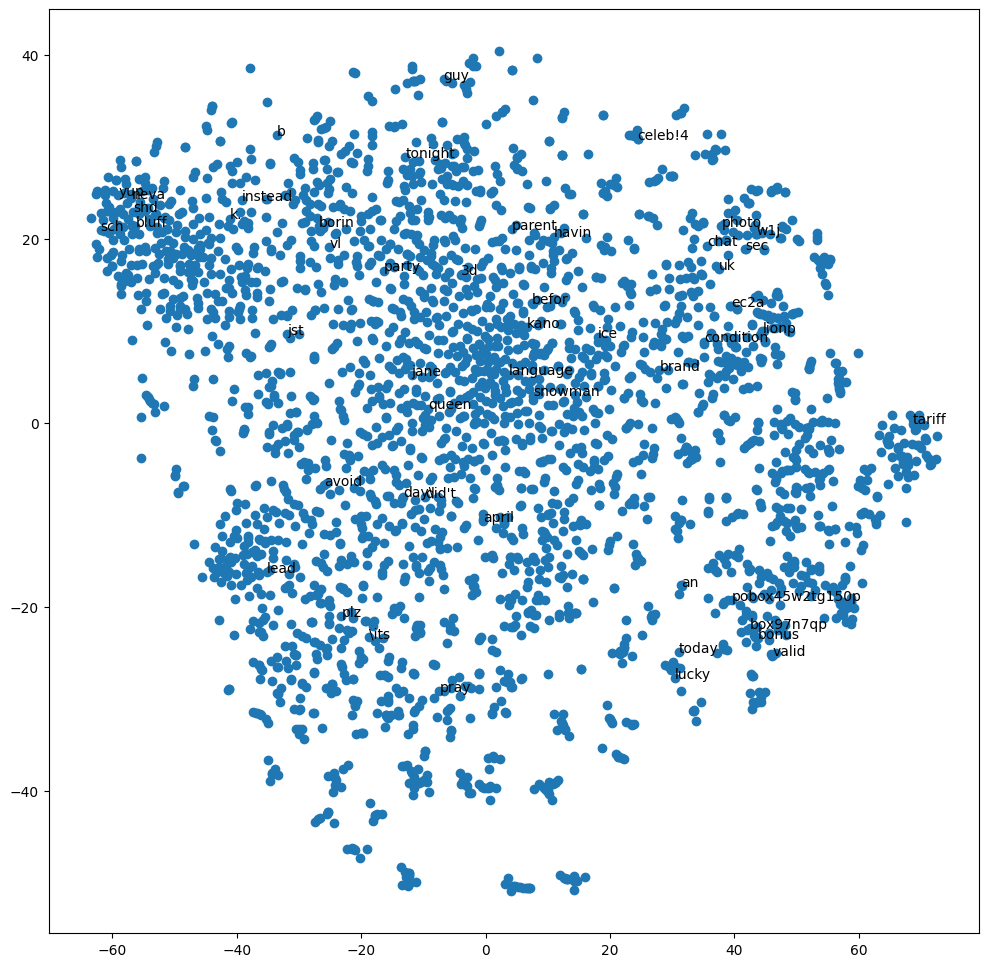

In [117]:
def reduce_dimensions(model):
    num_dimensions = NUM_DIMENSIONS

    # Извлечь слова и их векторы в виде numpy массивов
    vectors = np.asarray(model.wv.vectors)
    labels = np.asarray(model.wv.index_to_key)

    # Уменьшить размерность, используя t-SNE
    tsne = TSNE(n_components=num_dimensions, random_state=42)
    vectors = tsne.fit_transform(vectors)

    x_vals = [v[0] for v in vectors]
    y_vals = [v[1] for v in vectors]

    return x_vals, y_vals, labels

x_vals, y_vals, labels = reduce_dimensions(model_sg)

def plot(x_vals, y_vals, labels):
    plt.figure(figsize=(12, 12))
    plt.scatter(x_vals, y_vals)
    indices = list(range(len(labels)))
    selected_indices = random.sample(indices, 50)

    for i in selected_indices:
        plt.annotate(labels[i], (x_vals[i], y_vals[i]))

plot(x_vals, y_vals, labels)
print(f"{labels[0]}: {(x_vals[0], y_vals[0])}")